In [61]:
# Import Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam

In [62]:
# Memanggil Dataset
Dataset = pd.read_csv('BBRI.JK.csv')
Dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-11,3545.393311,3545.393311,3481.758057,3509.030273,2840.034912,51418628
1,2019-03-12,3527.211914,3536.302490,3463.576416,3490.848877,2825.319824,69851316
2,2019-03-13,3454.485840,3463.576416,3436.304199,3445.395020,2788.531494,51432598
3,2019-03-14,3436.304199,3499.939453,3436.304199,3490.848877,2825.319824,99175072
4,2019-03-15,3545.393311,3590.847168,3536.302490,3590.847168,2906.253662,106867285


In [63]:
# Filter Data
Dataset= Dataset[['Date','High']]
Dataset.head()

,Date,High
0,2019-03-11,3545.393311
1,2019-03-12,3536.302490
2,2019-03-13,3463.576416
3,2019-03-14,3499.939453
4,2019-03-15,3590.847168


In [64]:
# Merubah tipe kolom date menjadi datetime
Dataset['Date'] = pd.to_datetime(Dataset['Date'])
Dataset.head()

,Date,High
0,2019-03-11,3545.393311
1,2019-03-12,3536.302490
2,2019-03-13,3463.576416
3,2019-03-14,3499.939453
4,2019-03-15,3590.847168


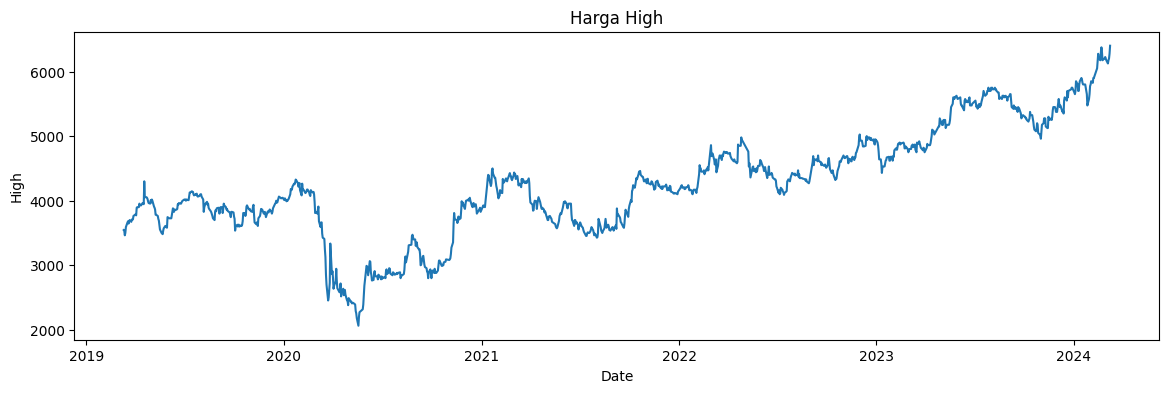

In [65]:
# Visualisasi Data pada dataset
plt.figure(figsize=(14, 4))
sns.lineplot(x=Dataset["Date"], y=Dataset["High"])
plt.title("Harga High")
plt.show()

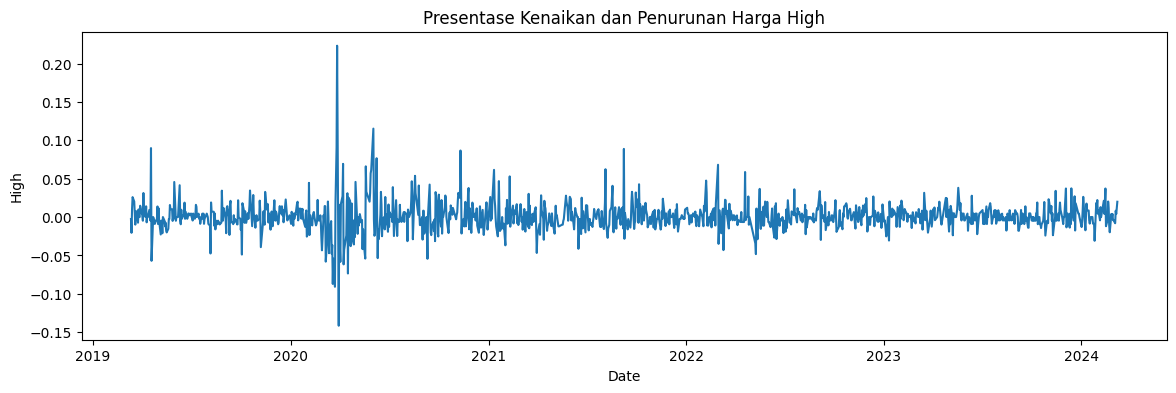

In [66]:
# Visualitasi presentasi kenaikan dan penurunan harga high pada dataset
plt.figure(figsize=(14, 4))
sns.lineplot(x=Dataset["Date"], y=Dataset["High"].pct_change())
plt.title("Presentase Kenaikan dan Penurunan Harga High")
plt.show()

In [67]:
# Split data menjadi data train dan data test
train_size = int(0.85 * len(Dataset))
test_size = len(Dataset) - train_size

univariate_df = Dataset[['Date', 'High']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

1044 185


In [68]:
from sklearn.preprocessing import MinMaxScaler

# Normalisasi data menggunakan MinMaxScaler
data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.65828965],
       [-0.66038605],
       [-0.67715712],
       [-0.66877159],
       [-0.64780771],
       [-0.6310367 ],
       [-0.6268439 ],
       [-0.63522944],
       [-0.6289403 ],
       [-0.62265116]])

In [69]:
# Defines the rolling window
look_back = 52

# Split menjadi train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

940 185


In [70]:
# Membuat Model LSTM denngan relu activation function
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25, activation='tanh'))
model.add(Dense(1))

# Compile dengan optimizer Adam
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Latih model
model.fit(x_train, y_train, batch_size=1, epochs=4, validation_data=(x_test, y_test))

# Print model summary
model.summary()

Epoch 1/4
940/940 [==============================] - 4s 2ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 2/4
940/940 [==============================] - 2s 2ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/4
940/940 [==============================] - 2s 2ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 4/4
940/940 [==============================] - 2s 2ms/step - loss: 0.0014 - val_loss: 0.0018
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 1, 128)            92672     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_10 (Dense)            (None, 25)                1625      
                                                                 
 dense_11 (Dense)            (None, 1)                

In [71]:
from colorama import Fore

# Prediksi model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Menghitung RMSE, MAE, dan MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
mape_test_predict = mean_absolute_percentage_error(y_test[0], test_predict[:,0])


print(Fore.YELLOW + 'MAPE Test Predictions: {:.2f}%'.format(mape_test_predict))
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.BLUE + 'MAE: {}'.format(score_mae))

6/6 [==============================] - 0s 1ms/step
MAPE Test Predictions: 2.45%
RMSE: 186.45589330187417
MAE: 141.25335726351358


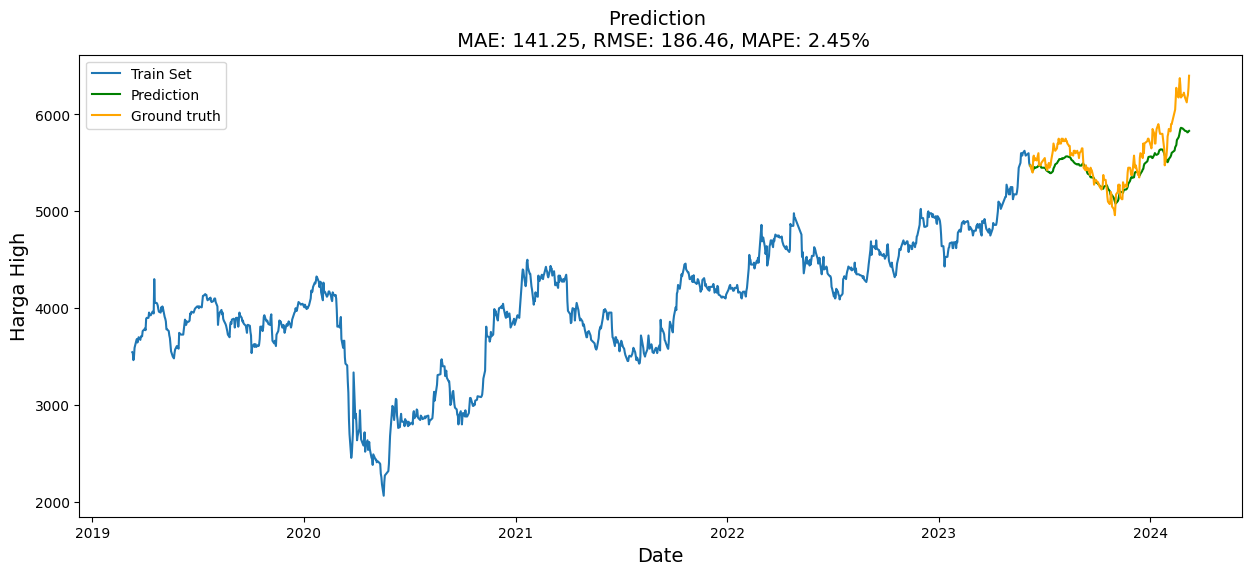

In [72]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Menampilkan hasil prediksi
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}, MAPE: {mape_test_predict:.2f}%', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Harga High', fontsize=14)

plt.show()